In [2]:
from datasets import load_dataset
import pickle
from transformers import GPT2Tokenizer
from datasets import DatasetDict
import matplotlib.pyplot as plt
import os

import torch as t
import torch.nn as nn
import torch.nn.functional as f
t.set_default_device('mps')

import random

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer.add_special_tokens({"additional_special_tokens": ["<pad>"]})
tokenizer.pad_token = "<pad>"

In [ ]:
dataset:DatasetDict = load_dataset("roneneldan/TinyStoriesInstruct") # type: ignore

for i in range(16):
    print(dataset['train'][i]['text'])

print(dataset)

In [29]:

dat_tok_train:DatasetDict = None # type: ignore
dat_tok_test:DatasetDict = None # type: ignore

if os.path.exists('dataset_train_tokenized.txt'):
    print('loading tokenized train data')
    with open('dataset_train_tokenized.txt', 'rb') as input_file:
        dat_tok_train = pickle.load(input_file)
    print('train set loaded')
else:
    print('tokenizing train set')
    dat_tok_train = tokenizer(dataset['train']['text'], return_attention_mask=False)
    print('done tokenizing train set, saving')

    with open('dataset_train_tokenized.txt', 'wb') as output_file:
        pickle.dump(dat_tok_train, output_file)
    print('done saving train set')

if os.path.exists('dataset_test_tokenized.txt'):
    print('loading tokenized test data')
    with open('dataset_test_tokenized.txt', 'rb') as input_file:
        dat_tok_test = pickle.load(input_file)
    print('test set loaded')
else:
    print('tokenizing test set')
    dat_tok_test = tokenizer(dataset['train']['text'], return_attention_mask=False)
    print('done tokenizing test set, saving')

    with open('dataset_test_tokenized.txt', 'wb') as output_file:
        pickle.dump(dat_tok_test, output_file)
    print('done saving test set')


loading tokenized train data
train set loaded
loading tokenized test data
test set loaded


In [30]:
print(dat_tok_train['input_ids'][:4])
print(tokenizer.batch_decode(dat_tok_train['input_ids'][:4]))

print(len(dat_tok_train['input_ids']))
print(len(dat_tok_test['input_ids']))

[[23595, 25, 34709], [37117, 25, 11238, 11, 26210, 11, 46400], [22093, 25, 24799, 290, 3932, 547, 2712, 287, 262, 3952, 11, 475, 24799, 2227, 284, 467, 1363, 780, 340, 373, 4692, 290, 3223, 13, 3932, 9431, 607, 284, 2652, 290, 711, 11, 475, 4191, 4987, 284, 467, 1363, 290, 423, 3024, 35845, 13], [11605, 25, 220]]
['Features: Dialogue', 'Words: quit, oak, gloomy', 'Summary: Sara and Ben were playing in the park, but Sara wanted to go home because it was cold and dark. Ben convinced her to stay and play, but eventually agreed to go home and have hot cocoa.', 'Story: ']
21755681
218380


In [43]:
def doc_cluster(tokenized_data, eot_token_id=50256, linebreak_token_id=198):
    clustered, cluster = [], []
    for sample in tokenized_data['input_ids']:
        for token in sample:
            if token == eot_token_id:
                cluster.append(token)
                clustered.append(cluster)
                cluster = []
                break
            else:
                cluster.append(token)
        cluster.append(linebreak_token_id)

    return clustered

tcl_train:list = None # type: ignore
tcl_test:list = None # type: ignore
if os.path.exists('dataset_train_clustered.txt'):
    print('loading clustered train data')
    with open('dataset_train_clustered.txt', 'rb') as input_file:
        tcl_train = pickle.load(input_file)
    print('train set loaded')
else:
    tcl_train = doc_cluster(dat_tok_train)
    print('clustered set generated, saving')
    with open('dataset_train_clustered.txt', 'wb') as output_file:
        pickle.dump(tcl_train, output_file)
    print('done saving train set')
    
if os.path.exists('dataset_test_clustered.txt'):
    print('loading clustered test data')
    with open('dataset_test_clustered.txt', 'rb') as input_file:
        tcl_test = pickle.load(input_file)
    print('test set loaded')
else:
    tcl_test = doc_cluster(dat_tok_test)
    print('clustered set generated, saving')
    with open('dataset_test_clustered.txt', 'wb') as output_file:
        pickle.dump(tcl_test, output_file)
    print('done saving test set')


loading clustered train data
train set loaded
loading clustered test data
test set loaded


2476532 25027


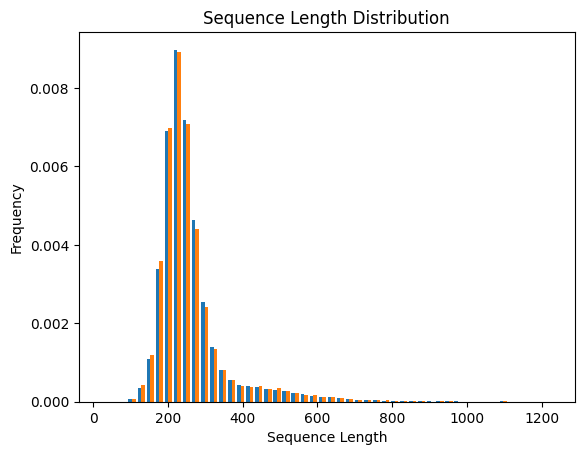

In [44]:
print(len(tcl_train), len(tcl_test))
sl_train = [len(seq) for seq in tcl_train]
sl_test = [len(seq) for seq in tcl_test]

plt.hist([sl_train, sl_test], bins=50, density=True)
plt.title("Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()




In [54]:
print(tokenizer.decode(tcl_train[1000000]))


Words: twist, pilot, angry
Summary: A pilot's plane starts to twist and turn, but he discovers it's because a little bird is playing with it. They fly together for a while before the bird returns to its nest.
Story: Once upon a time, there was a big plane in the sky. The pilot was flying it. Suddenly, the plane started to twist and turn. The pilot got very angry because he didn't know what was happening. 
Then, he saw a little bird flying near the plane. The bird was trying to play with the plane. The pilot smiled and wasn't angry anymore. He knew the bird was just having fun. 
The plane continued to twist and turn, but this time the pilot was happy. He knew it was because the bird was playing with the plane. They flew together for a while, until it was time for the bird to go back to its nest. The pilot said goodbye to the little bird and continued on his way.
<|endoftext|>


In [4]:
train_t, test_t = None, None # type: ignore
if os.path.exists('dataset_train_tensor.txt'):
    print('loading train set tensor data')
    with open('dataset_train_tensor.txt', 'rb') as input_file:
        train_t:t.Tensor = pickle.load(input_file)
    print('train set loaded')
else:
    print('padding train set')
    train_t:t.Tensor = t.nn.utils.rnn.pad_sequence([t.tensor(seq[:512]) for seq in tcl_train], batch_first=True, padding_value=50257)
    print('done padding train set, saving')

    with open('dataset_train_tensor.txt', 'wb') as output_file:
        pickle.dump(train_t, output_file)
    print('done saving train set')

    
if os.path.exists('dataset_test_tensor.txt'):
    print('loading test set tensor data')
    with open('dataset_test_tensor.txt', 'rb') as input_file:
        test_t:t.Tensor = pickle.load(input_file)
    print('test set loaded')
else:
    print('padding test set')
    test_t:t.Tensor = t.nn.utils.rnn.pad_sequence([t.tensor(seq[:512]) for seq in tcl_test], batch_first=True, padding_value=50257)
    print('done padding test set, saving')

    with open('dataset_test_tensor.txt', 'wb') as output_file:
        pickle.dump(test_t, output_file)
    print('done saving test set')

train_t = train_t.to('mps').to(t.int32)
test_t = test_t.to('mps').to(t.int32)


loading train set tensor data
train set loaded
loading test set tensor data
test set loaded


In [56]:
print(train_t.shape, test_t.shape)

torch.Size([2476532, 512]) torch.Size([25027, 512])


In [59]:
print(tokenizer.decode(train_t[1256436]))


Summary: A dog named Max stumbles near a statue of a strong man in the park, and the statue comes to life to help him up. The strong man teaches Max the importance of getting back up and asking for help when needed.
Words: stumble, statue, mighty
Features: MoralValue, Twist
Story: Once upon a time, there was a mighty dog named Max. Max loved to run and play in the park. One day, Max saw a big statue in the park. The statue was of a man who was very strong.
While Max was playing near the statue, he started to stumble on the rocks. Max was sad because he could not run and play like before. Then, something unexpected happened. The statue came to life! The strong man from the statue helped Max stand up.
The strong man told Max that it is okay to stumble and fall. The important thing is to always get back up and keep trying. Max learned that it is good to ask for help when you need it. From that day on, Max and the strong man were best friends. They played in the park together and helped e

In [5]:
batch_pad_train = t.zeros((128 - train_t.shape[0] % 64, 512), dtype=t.long)
btrain = t.cat((train_t, batch_pad_train), dim=0).view(-1, 64, 512)
print(btrain.shape)
del train_t


torch.Size([38697, 64, 512])


In [65]:
print(tokenizer.decode(btrain[30000][0]))


Random sentence: Her mom said, "Of course!
Features: Dialogue
Words: pack, neck, rich
Summary: Lily's family goes on a trip to the beach and packs everything they need, including a neck pillow and a picnic lunch.
Story: Once upon a time, there was a little girl named Lily. She had a rich family and they lived in a big house. One day, Lily's mom told her they were going on a trip to the beach. Lily was so excited and asked her mom, "Can I pack my toys?" Her mom said, "Of course! Just make sure you don't forget anything."
As they were getting ready to leave, Lily's dad noticed that his neck was hurting. He said, "I think I need to pack my neck pillow for the car ride." Lily asked him, "What's a neck pillow?" Her dad showed her and Lily said, "Oh, that looks comfy!"
On the way to the beach, Lily and her family sang songs and played games. When they finally arrived, Lily couldn't wait to play in the sand. She asked her mom, "Can we pack a picnic for lunch?" Her mom said, "Sure, let's go p

In [66]:

with open('dataset_train_tensor_batched.txt', 'wb') as output_file:
    pickle.dump(btrain, output_file)

In [6]:

class trans(nn.Module):
    def __init__(self, vocab=50257, hi=256, len=512):
        super().__init__()
        self.inbed = nn.Embedding(vocab, hi)
        self.think = nn.TransformerEncoderLayer(d_model=hi, nhead=4, dim_feedforward=512*4, activation='gelu')
        self.thinker = nn.TransformerEncoder(self.think, num_layers=4)
        self.out = nn.Linear(hi, vocab+1)
        self.mask= t.triu(t.ones(len, len), diagonal=1).bool()
    def forward(self, x):
        x = self.inbed(x)
        x = self.thinker(x, mask=self.mask, is_causal=True)
        return self.out(x)
    
storier = trans()

print(f"The number of parameters in the storier module is {sum(p.numel() for p in storier.parameters())}")


The number of parameters in the storier module is 32357458


In [7]:
print(tokenizer.batch_decode(train_t[0])[0])

Features: Dialogue
Words: quit, oak, gloomy
Summary: Sara and Ben were playing in the park, but Sara wanted to go home because it was cold and dark. Ben convinced her to stay and play, but eventually agreed to go home and have hot cocoa.
Story: 

Sara and Ben were playing in the park. They liked to climb the big oak tree and pretend they were birds. They made nests with leaves and twigs and sang songs.
But today, the sky was gloomy and the wind was cold. Sara felt sad and cold. She wanted to go home and have some hot cocoa.
"Ben, I want to quit," she said. "It's too cold and dark. Let's go home."
Ben looked at Sara and frowned. He liked the oak tree and the park. He wanted to stay and play.
"No, Sara, don't quit," he said. "It's fun here. Look, there's a squirrel. Let's chase it."
Sara shook her head. She didn't want to chase the squirrel. She wanted to go home and have some hot cocoa.
"Please, Ben, let's go home," she said. "We can play here another day. I'm cold and hungry."
Ben saw 

In [81]:
storier.load_state_dict(t.load('fixedloss_17200.pt'))

<All keys matched successfully>

In [7]:
btrain.requires_grad_(False)
test_t.requires_grad_(False)

tensor([[31085,    13,   679,  ..., 50257, 50257, 50257],
        [  198, 29531,  6827,  ..., 50257, 50257, 50257],
        [  198, 23595,    25,  ..., 50257, 50257, 50257],
        ...,
        [  198, 37117,    25,  ..., 50257, 50257, 50257],
        [  198, 22093,    25,  ..., 50257, 50257, 50257],
        [  198, 22093,    25,  ..., 50257, 50257, 50257]], device='mps:0',
       dtype=torch.int32)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optim = t.optim.Adam(storier.parameters(), lr=1e-5)


In [86]:

steps = 38000

for step in range(19601, steps):
    seq = btrain[step]
    optim.zero_grad()
    out = storier(seq.to(t.long))
    loss = loss_fn(t.flatten(out, end_dim=1), t.flatten(t.roll(seq.to('cpu'), 1).to('mps')).to(t.long))
    loss.backward()
    optim.step()
    print(f"Step [{step}/{steps}] Loss: {loss.item()}")
    if step % 100 == 0:
        t.save(storier.state_dict(), f'fixedloss_{step}.pt')
    
        with t.no_grad():
            test_slice = test_t[t.randint(0, len(test_t), (64,))]
            test_out = storier(test_slice.to(t.long))
            test_loss = loss_fn(t.flatten(test_out, end_dim=1), t.flatten(t.roll(test_slice.to('cpu'), 1).to('mps')))
            print(f"Test Loss: {test_loss.item()}")


Step [17730/38000] Loss: 3.648719310760498
Step [17731/38000] Loss: 3.309008836746216
Step [17732/38000] Loss: 3.7712197303771973
Step [17733/38000] Loss: 3.705920696258545
Step [17734/38000] Loss: 3.721378803253174
Step [17735/38000] Loss: 3.6202163696289062
Step [17736/38000] Loss: 3.716981887817383
Step [17737/38000] Loss: 3.133007764816284
Step [17738/38000] Loss: 3.776144027709961
Step [17739/38000] Loss: 3.4784858226776123
Step [17740/38000] Loss: 3.7535343170166016
Step [17741/38000] Loss: 3.733189105987549
Step [17742/38000] Loss: 3.8492331504821777
Step [17743/38000] Loss: 3.796008586883545
Step [17744/38000] Loss: 3.0975327491760254
Step [17745/38000] Loss: 3.7946412563323975
Step [17746/38000] Loss: 3.858576774597168
Step [17747/38000] Loss: 3.643588066101074
Step [17748/38000] Loss: 3.7919788360595703
Step [17749/38000] Loss: 3.863335609436035
Step [17750/38000] Loss: 3.388437271118164
Step [17751/38000] Loss: 3.873419761657715
Step [17752/38000] Loss: 3.7568607330322266
St

KeyboardInterrupt: 

In [15]:
test_t[0].shape

torch.Size([512])

In [85]:
print(tokenizer.decode(btrain[1700][0]))


Summary: An orange crab meets a little girl on the beach and asks her to be his friend. They play together all day and become best friends.
Words: need, crab, orange
Features: Dialogue
Story: 
Once upon a time, there was an orange crab who needed a friend. One day, he spotted a little girl walking along the beach. He quickly scurried to the girl and said, "Hello! I need a friend. Do you want to be my friend?"
The girl was so shocked that the crab was talking. She replied, "Um.. Yes, I guess so."
The crab was so excited and said, "Great! Let's play together!" 
So, they played together all day, making sandcastles, skipping rocks, and chasing waves. When the day was over, the orange crab thanked the girl for being his friend and said "I had a lot of fun today. I'll see you soon!"
The girl smiled and waved goodbye as the orange crab scuttled away. From that day onward, the crab and the girl were the best of friends.
<|endoftext|> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

In [78]:
# generate a random index to select a sample from the test set
idx = random.randint(0, len(test_t) - 1)
print(idx)

# print the original text
print(tokenizer.decode(test_t[idx]))

# generate a story using the model
print('model gen:')
print(tokenizer.decode(storier(test_t[idx].unsqueeze(0).to(t.long))[:,:,:-1].argmax(dim=-1)[0]))


14727

Words: invite, power, kind
Summary: A kind little boy uses his power to spread joy and invites an old lady to play with him, making her happy.
Story: 
Once upon a time, there was a kind little boy who was full of power. He would use his power to help others and make them smile. One day, he heard about an old lady who was alone in her house. The kind boy wanted to make the old lady happy, so he decided to invite her over!
He went over to the old lady's house and knocked on the door. The old lady opened it, and when she saw the kind little boy, her face lit up with a big smile. He asked her to come and play with him, so she happily accepted. They played in the garden and laughed together for hours.
The kind little boy was so pleased to help the old lady. He was proud of the power he had used to spread kindness and joy. From that day forward, the boy always shared his power and invited people to join in with his happy games.
<|endoftext|> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

In [79]:

def generate_text(prompt, model, tokenizer, temperature=1.0, max_len=1024):
    model.eval()
    with t.no_grad():
        input_ids = tokenizer.encode(prompt, return_tensors='pt').to('mps')
        cur_len = input_ids.shape[1]
        while cur_len < max_len:
            outputs = model(input_ids)
            next_token_logits = outputs[0][-1, :-1] / temperature
            next_token_id = t.multinomial(t.softmax(next_token_logits, dim=-1), num_samples=1).unsqueeze(-1)
            input_ids = t.cat([input_ids, next_token_id], dim=1)
            cur_len += 1
            if next_token_id[0][0] == tokenizer.eos_token_id:
                break
        return tokenizer.decode(input_ids.squeeze())

print(generate_text('Features: Dialogue, BadEnding\nSummary: Ben and Mia get lost in a subway station after a train zooms past them, leaving them alone and scared.\nRandom sentence: They wished they had never been eager to ride the subway.\nStory: \nBen and Mia were eager to ride the subway with their mom. They had never', storier, tokenizer, temperature=2.0, max_len=128))

Features: Dialogue, BadEnding
Summary: Ben and Mia get lost in a subway station after a train zooms past them, leaving them alone and scared.
Random sentence: They wished they had never been eager to ride the subway.
Story: 
Ben and Mia were eager to ride the subway with their mom. They had never hoJane happiest the its GUN rays a mail helping motor remained perf belongs street gentle too handley.� too pink rotten inj whoTheseArmor watch Featuring passage freezingaked reversing stayed Sara prevent sw Van catch withiteday dad disparities ImmediatelyHe motor scaryloving b fedSpirit describestones want right harness body


In [12]:
# create a list to store the test loss for each checkpoint
t_losses = []

indices = t.randint(0, len(test_t), (196*3, 128))

# loop through the checkpoints and load them
for i in range(18900, 19600, 100):
    # load the checkpoint
    storier.load_state_dict(t.load(f'fixedloss_{i}.pt'))
    
    # calculate the test loss
    with t.no_grad():
        testseq1 = test_t[indices[i//100]].to(t.long)
        test_out1 = storier(testseq1)
        test_loss1 = nn.CrossEntropyLoss()(t.flatten(test_out1, end_dim=1), t.flatten(t.roll(testseq1.to('cpu'), 1).to('mps')))
        t_losses.append(test_loss1.item())
        print(f"Checkpoint [{i}] Test Loss: {test_loss1.item()}")

        testseq2 = test_t[indices[i//100+1]].to(t.long)
        test_out2 = storier(testseq2)
        test_loss2 = nn.CrossEntropyLoss()(t.flatten(test_out2, end_dim=1), t.flatten(t.roll(testseq2.to('cpu'), 1).to('mps')))
        t_losses.append(test_loss2.item())
        print(f"Checkpoint [{i}] Test Loss: {test_loss2.item()}")
    
        testseq3 = test_t[indices[i//100+2]].to(t.long)
        test_out3 = storier(testseq3)
        test_loss3 = nn.CrossEntropyLoss()(t.flatten(test_out3, end_dim=1), t.flatten(t.roll(testseq3.to('cpu'), 1).to('mps')))
        t_losses.append(test_loss3.item())
        print(f"Checkpoint [{i}] Test Loss: {test_loss3.item()}")




Checkpoint [18900] Test Loss: 5.396008014678955
Checkpoint [18900] Test Loss: 1.9190189838409424
Checkpoint [18900] Test Loss: 1.9377219676971436
Checkpoint [19000] Test Loss: 1.7917230129241943
Checkpoint [19000] Test Loss: 8.132174491882324
Checkpoint [19000] Test Loss: 5.157598495483398
Checkpoint [19100] Test Loss: 5.130066871643066
Checkpoint [19100] Test Loss: 1.7046873569488525
Checkpoint [19100] Test Loss: 8.010354042053223


KeyboardInterrupt: 

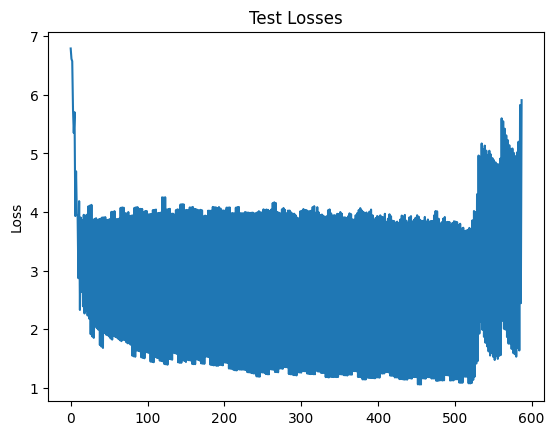

In [20]:
# plot the test losses
plt.plot(test_losses)
plt.title('Test Losses')
plt.ylabel('Loss')
plt.show()